# Interactive CosmoSIS Postprocessing

The CosmoSIS postprocessing code generates plots and statistics from all the different kinds of sampler that CosmoSIS supports. The usual way to use it is via the `cosmosis-postprocess` command, but you can also use it interactively, from a notebook, for example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cosmosis.postprocess import parser
from cosmosis.postprocessing.inputs import read_input
from cosmosis.postprocessing.postprocess import postprocessor_for_sampler
from cosmosis.postprocessing.plots import MetropolisHastingsPlots2D, MetropolisHastingsPlots1D
import os

This notebook is designed to be run from the main directory, so let's move there.

In [2]:
if os.getcwd().endswith("cosmosis-standard-library/examples"):
    os.chdir("..")

## Loading the chain

The read_input function can either read a chain file or the parameter ini file that you ran cosmosis on.
Then we can make a postprocessor object for that sampler, which knows how to burn, thin, plot, and weight different kinds of chains.


You can get a list of the options that can be given here using `parser.print_usage()`
The fact that `no_2d` is needed here is a bug - we will fix it soon.



In [3]:
sampler, ini = read_input("examples/pantheon.ini")
os.makedirs("output/pantheon", exist_ok=True)
proc = postprocessor_for_sampler(sampler)(ini, "Pantheon", 0, burn=3000, no_2d=False)


LOADING CHAIN FROM FILE:  output/pantheon.txt


The list of arrays `proc.data` contains the actual chain data, which can be useful if you want to make your own plots.

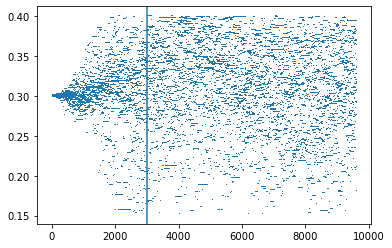

In [4]:
plt.plot(proc.data[0][:,0], ',')
plt.axvline(3000) # check that the burn-in above is enough

The `reduced_col` method gives you a column with any burn-in or thinning applied.

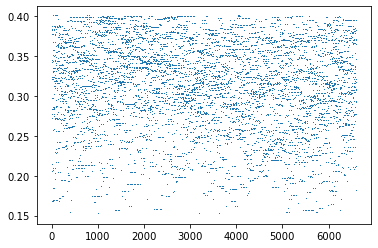

In [5]:
plt.plot(proc.reduced_col('cosmological_parameters--omega_m'), ',')

## Automatic postprocessing

The `proc.elements` attribute shows all the different plotting and stats classes that will be run.

The `run` method will run all those different steps.

<class 'cosmosis.postprocessing.plots.MetropolisHastingsPlots1D'>
<class 'cosmosis.postprocessing.plots.MetropolisHastingsPlots2D'>
<class 'cosmosis.postprocessing.statistics.MetropolisHastingsStatistics'>
<class 'cosmosis.postprocessing.statistics.MetropolisHastingsCovariance'>
<class 'cosmosis.postprocessing.statistics.Citations'>


 - 1D plot  cosmological_parameters--omega_m
 - 1D plot  cosmological_parameters--h0
 - 1D plot  cosmological_parameters--omega_k
 - 1D plot  supernova_params--m
(Making 2D plots using KDE; this takes a while but is really cool)
  (making cosmological_parameters--omega_m vs cosmological_parameters--h0)
  (making cosmological_parameters--omega_m vs cosmological_parameters--omega_k)
  (making cosmological_parameters--omega_k vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_m)
  (making supernova_params--m vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_k)
Samples 

/Users/jzuntz/src/cosmosis/env/lib/python3.9/site-packages/cosmosis/plotting/kde.py:33: RuntimeWarning: invalid value encountered in true_divide
  normalized_points.append((column-col_mean)/col_std)


['./cosmological_parameters--omega_m.png',
 './cosmological_parameters--h0.png',
 './cosmological_parameters--omega_k.png',
 './supernova_params--m.png',
 './2D_cosmological_parameters--omega_m_cosmological_parameters--h0.png',
 './2D_cosmological_parameters--omega_m_cosmological_parameters--omega_k.png',
 './2D_cosmological_parameters--omega_k_cosmological_parameters--h0.png',
 './2D_supernova_params--m_cosmological_parameters--omega_m.png',
 './2D_supernova_params--m_cosmological_parameters--h0.png',
 './2D_supernova_params--m_cosmological_parameters--omega_k.png',
 './means.txt',
 './medians.txt',
 './best_fit.txt',
 './low95.txt',
 './upper95.txt',
 './low68.txt',
 './upper68.txt',
 './lerr68.txt',
 './uerr68.txt',
 './lerr95.txt',
 './uerr95.txt',
 './peak1d.txt',
 './covmat.txt',
 './proposal.txt',
 './citations.txt']

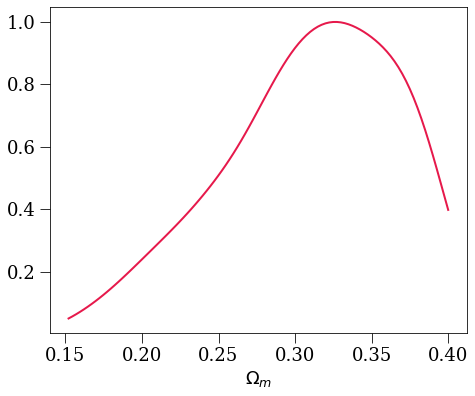

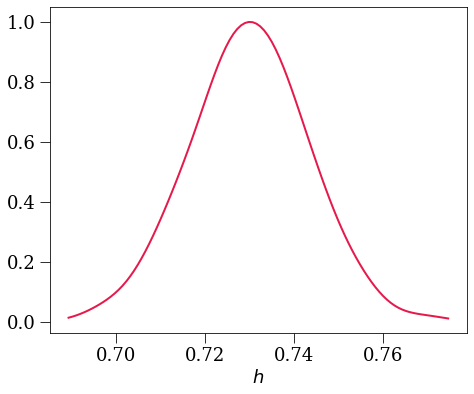

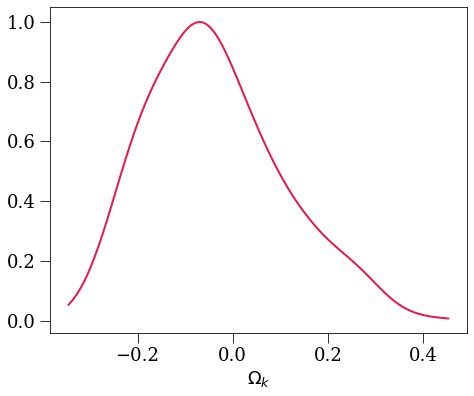

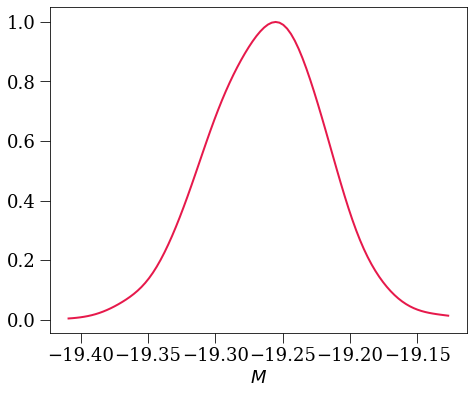

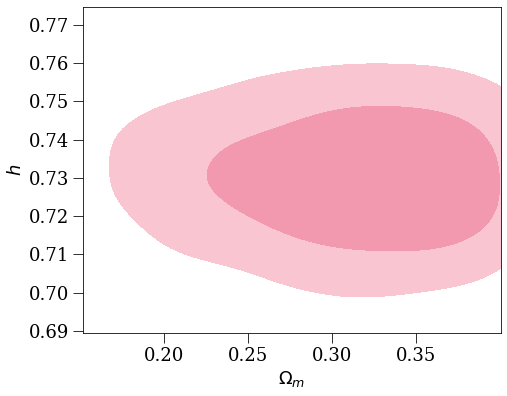

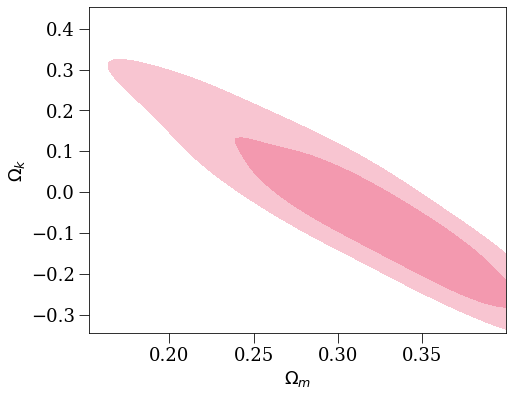

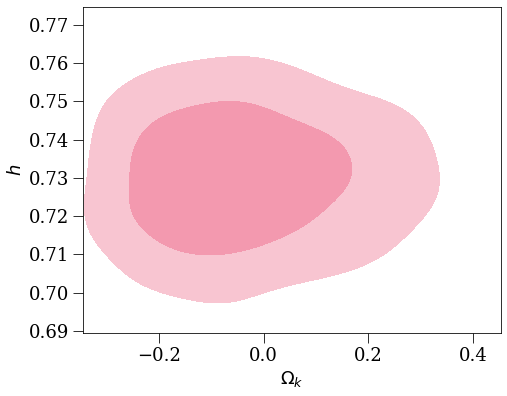

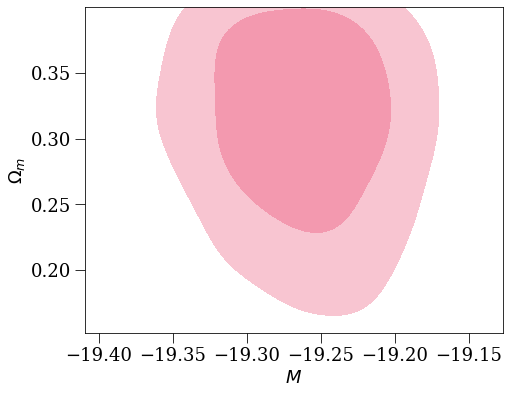

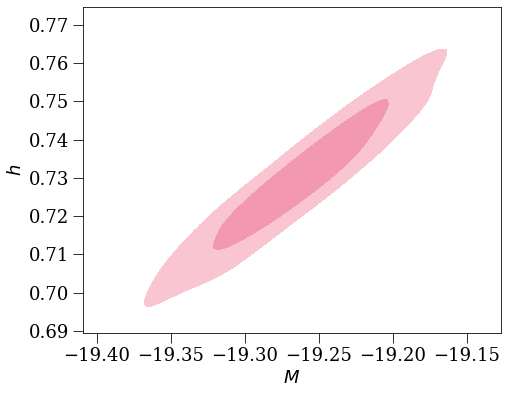

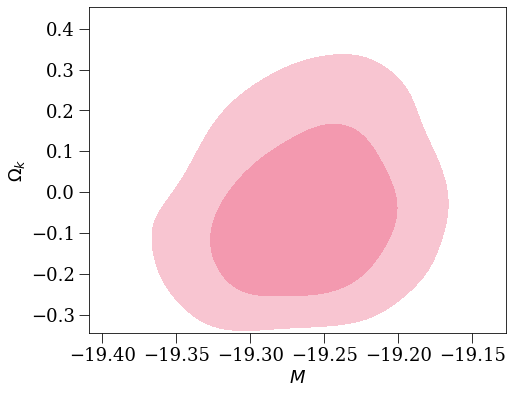

In [6]:
for p in proc.elements:
    print(p)
print("\n")
proc.run()

## Manual Control

If we want finer-grained control we can also make and use a specific postprocessor element.  For example, let's make some 2D plots.

  (making cosmological_parameters--omega_m vs supernova_params--m)
  (making cosmological_parameters--h0 vs supernova_params--m)


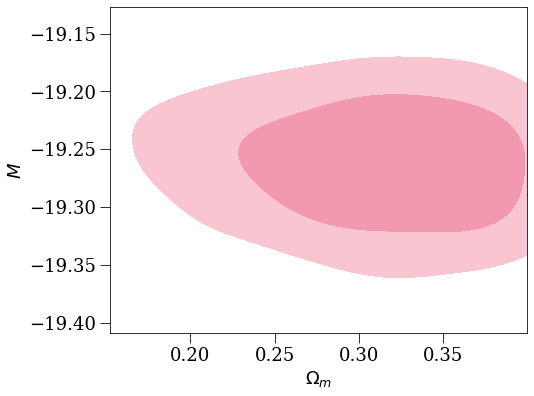

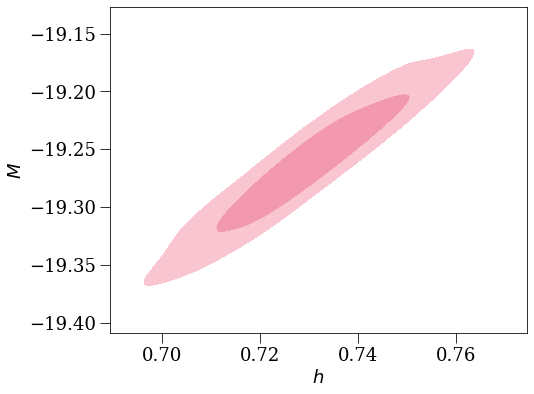

In [7]:
plotter = MetropolisHastingsPlots2D(proc)

fig = plt.figure()
plotter.make_2d_plot("cosmological_parameters--omega_m", "supernova_params--m", fig)

fig = plt.figure()
plotter.make_2d_plot("cosmological_parameters--h0", "supernova_params--m", fig)



You can get even more fine-grained control by using the methods on the `plotter` object itself. 
`get_reduced_col` will get you a column with any burn-in or thinning removed. 


Text(0, 0.5, 'Likelihood')

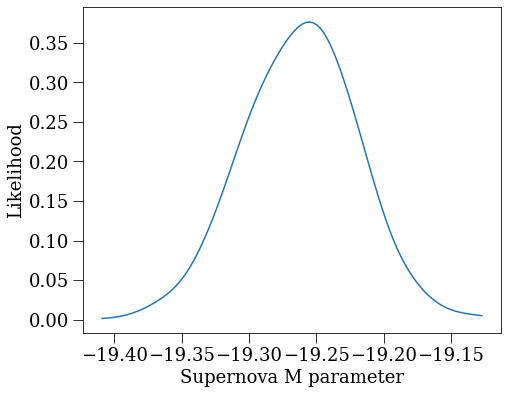

In [8]:
plotter = MetropolisHastingsPlots1D(proc)
x = plotter.reduced_col("supernova_params--m")
# This second name 
x, L = plotter.smooth_likelihood(x, "supernova_params--m")
plt.figure()
plt.plot(x, L)
plt.xlabel("Supernova M parameter")
plt.ylabel("Likelihood")

## Using derived parameters

You can easily add simple derived parameters using the `derive_extra_column` method.  Once this is run, the new column can be used in plots and stats.

  (making cosmological_parameters--ommh2 vs supernova_params--m)


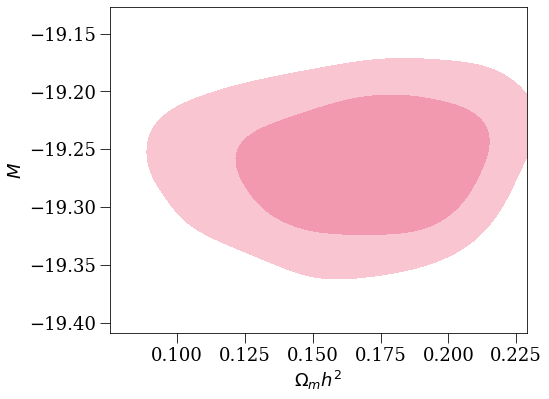

In [9]:
def ommh2(chain):
    h = chain['cosmological_parameters--h0']
    omm = chain['cosmological_parameters--omega_m']
    name = "cosmological_parameters--ommh2"
    return omm * h**2, name

proc.derive_extra_column(ommh2)

fig = plt.figure()
plotter = MetropolisHastingsPlots2D(proc)
plotter.make_2d_plot("cosmological_parameters--ommh2", "supernova_params--m", fig)
